## C S 329E HW 9

# Clustering with K-means and DBSCAN

## Kieran Cosgrove and Alec Biggerstaff

For this week's homework we are going explore two clustering methods:

  - K-Means, and
  - DBSCAN
  
As we discussed in lecture, k-means creates clusters based on a distance measure, and DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, we will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementations. 

In [1]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Part 1 : K-Means

In the first half of the homework, we will implement the Algorithm 7.1 "Basic K-means", and apply that algorithm to a small data set provided with the assignment in the `data_kmeans.csv` file. We will build up some helper functions along the way, test them, and put it all together to apply to our small example data set. 

In [2]:
# loading in our toy data
df_kmeans = pd.read_csv('data_kmeans.csv')

## Q1.1 - Write a function that returns `k` random rows from a data frame

To initialize the centroids, we pick `k` random points from a data frame.  Write a function `init_centroids( df_data, k )` that accepts two parameters: a data frame `df_data`, and an integer `k`, and returns the initial centroids for our k-means algorithm.  Note, we want the indices of the returned data frame to range from 0 - (k-1) so that we can use these as the centroid labels.  Use [pandas sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method, and pass it the value of $42$ for `random_state`. 

In [3]:
def init_centroids( df_data, k ):
    return df_data.sample(n=k,random_state=42)

In [4]:
# Testing our init centroid function
df_centroids = init_centroids( df_kmeans, 7 )
df_centroids

,x,y
407,-0.633437,0.488756
444,-0.597736,0.632194
117,-0.635867,0.166613
30,-0.539351,-0.875532
415,-0.588597,0.293062
157,-0.127985,-0.136639
325,0.342579,0.211717


## Q1.2 - Write a function to assign every row in a data frame to a centroid 

Write a function, `assign_to_centroid`, that accepts two parameters: a data frame, `df_data`, that represents our data to be clustered, and the data frame, `df_centroids`, which is of length `k` and contains the current centroids for our clusters.  The functions returns a series of the same length of `df_data` that contains the index of the closest centroid in `df_centroid`.  Use Euclidean distance as your distance measure. 

For example, if a row of data contained the data point $(100,123)$ and the three centroids were in a data frame that had the following information:

  - Index 0 : (34,34)
  - Index 1 : (0,1)
  - Index 2 : (83,99)

The `assign_to_centroid` function would assign the index $2$ to that row of data. 

In [5]:
def distance(a, b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

In [6]:
def assign_to_centroid( df_data, df_centroids ):
    return_df = df_data.copy()
    return_df['df_centroid'] = None
    
    for index, row in df_data.iterrows():
        distances = [distance(centroid, row) for _, centroid in df_centroids.iterrows()]
        return_df.at[index,"df_centroid"] = distances.index(min(distances))
        
    return return_df["df_centroid"]

In [7]:
# Check how many data points were assigned to each centroid
s_centroid_assignment = assign_to_centroid( df_kmeans, df_centroids )
s_centroid_assignment.value_counts()

6    126
1     94
3     71
5     58
0     53
2     26
4     22
Name: df_centroid, dtype: int64

## Q1.3 - Write a function that recomputes the centroids

Write a function `compute_centroids` that takes two parameters: the data frame, `df_data` containing the data being clustered, and a series of the same length that contains the label of the assigned centroid for every row in df_data, `s_centroid_assignment`. The function will return the a data frame containing the centroids (mean) value for each unique centroid. 

Note that the indices in the returned data frame should correspond to the unique values in `s_centroid_assignment`.  For example, if I found the mean value of df_data using the slice corresponding to `s_centroid_assigment == 2`, then the centroid should be in the returned data frame at `.iloc[2]`. 


In [8]:
def compute_centroids( df_data, s_centroid_assignment ):
    return_df = s_centroid_assignment.value_counts().to_frame()
    return_df['center_x'], return_df['center_y'] = 0.0, 0.0
    
    for index, row in df_data.iterrows():
        return_df.at[s_centroid_assignment[index], 'center_x'] += row['x']
        return_df.at[s_centroid_assignment[index], 'center_y'] += row['y']
        
    return_df['center_x'] = return_df['center_x'] / return_df['df_centroid']
    return_df['center_y'] = return_df['center_y'] / return_df['df_centroid']
    return return_df[['center_x','center_y']]
    

In [9]:
# Test it out
df_new_centroids = compute_centroids( df_kmeans, s_centroid_assignment)
df_new_centroids

,center_x,center_y
6,0.523364,0.238569
1,-0.721574,0.708343
3,-0.696694,-0.699028
5,-0.102365,-0.188876
0,-0.715983,0.500552
2,-0.738268,-0.113830
4,-0.546913,0.321364


## Q1.4 - Write a function that compares two centroid data frames

The stopping criterion for k-means is when our centroids have not moved since the last iteration.  Write a function `compare_centroids` that is given 2 centroid data frames, `df_centroid_a`, and `df_centroid_b` as parameters and returns `True` or `False` indicating if the centroids at each unique index in the data frame are equal. Use the [equals](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.equals.html) method to compare equality of pandas Series objects. 

In [10]:
def compare_centroids( df_centroid_a, df_centroid_b ):
    return df_centroid_a.equals(df_centroid_b)

In [11]:
# Test it out, should print True followed by False
print(compare_centroids( df_new_centroids, df_new_centroids ))
print(compare_centroids( df_new_centroids, df_centroids ))

True
False


## Q1.5 - Write a function that implements k-means

Write a function, `k_means`, that takes in as parameters 2 values, a data frame with values to cluster, `df_data`, and the number of clusters to form, `k`.  The function should return a series of data of the same length as `df_data` that contains the cluster assignment (an integer from 0 to (k-1)) for each row of data.  Use the helper functions defined in the prior questions. 

In [12]:
def k_means( df_data, k ):
    df_centroids = init_centroids( df_data, k )
    while True:
        s_centroid_assignment = assign_to_centroid( df_data, df_centroids )
        df_new_centroids = compute_centroids( df_data, s_centroid_assignment)
        if compare_centroids(df_centroids, df_new_centroids):
            return s_centroid_assignment
        df_centroids = df_new_centroids

In [13]:
# Call k_means with k = 5 to test
s_cluster_assignment = k_means( df_kmeans, 5)
s_cluster_assignment.value_counts()

0    178
1     89
2     74
3     63
4     46
Name: df_centroid, dtype: int64

## Q1.6 - Plot the results

Plot the points in the `df_kmeans` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`).  Label your axes, and give the plot a title. 

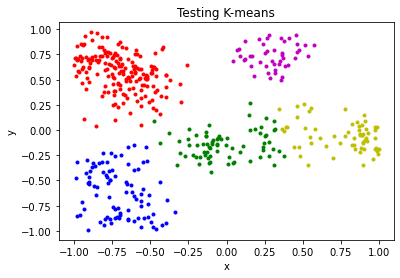

In [14]:
# Plot each cluster
# your code here  
symbols = ['r', 'b', 'g', 'y', 'm']
for index, row in df_kmeans.iterrows():
    plt.scatter(row['x'], row['y'], marker = '.', c = symbols[s_cluster_assignment[index]])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing K-means')
plt.show()

# Part 2 : DBSCAN

## Q2.1 Load the Density Data and try K-means

Load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. Label your axes, and give the plot a title. 

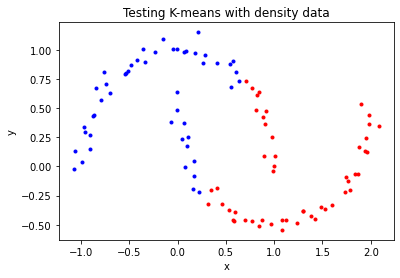

In [15]:
df_dbscan = pd.read_csv('data_dbscan.csv')

# Call k_means with k = 2
s_cluster_assignment = k_means( df_dbscan, 2)

# your code here
for index, row in df_dbscan.iterrows():
    plt.scatter(row['x'], row['y'], marker = '.', c = symbols[s_cluster_assignment[index]])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing K-means with density data')
plt.show()

## Q2.2 Write function to Implement Range Query

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in our data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice should be preserved (do not reset_index).  

In [16]:
def range_query( df_data, q_index, eps ):
    neighbors = []
    for index, row in df_data.iterrows():
        if distance(row, df_data.iloc[q_index]) < eps:
            neighbors += [index]
    return df_data.iloc[neighbors,:]

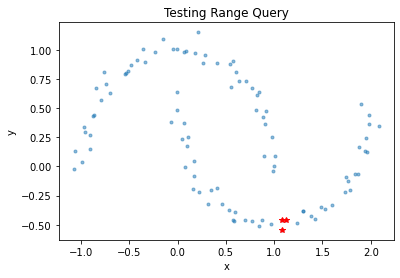

In [17]:
# Test it out
df_n = range_query( df_dbscan, 0, 0.1 )
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Q2.3 Write a function to implement DBSCAN

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement DBSCAN. This algorithm uses set notation, I found a handy summary on-line [here](http://www.math.cmu.edu/~bkell/21110-2010s/sets.html) if you need a refresher. 

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

The function should accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`.  The function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

Don't forget that [iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) is a lovely way to loop through a data frame. But if you modify the dataframe within the loop, it doesn't add more iterations to the loop.  For example, if you start with a dataframe of length $n$ and add $3$ rows, then the `iterrows` will stop after $n$ rows. For the inside loop, you'll need to use a native python list to dynamically grow the `SeedSet S`.  You can use the `extend` function to merge 2 lists together. For example:

```
x = [1,2,3]
y = [4,5,6]
x.extend(y) # sets x to the list [1, 2, 3, 4, 5, 6]
```

If you haven't used the [continue](https://docs.python.org/3/tutorial/controlflow.html) statement before, it can be useful in these situations, check out the link. 

Call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments` 

In [18]:
def dbscan( df_data, eps, min_pts ):
    NOISE_LABEL = 0
    C = 0

    label = len(df_data)*[-1]
    for p_index, row in df_data.iterrows():
        if label[p_index] != -1:
            continue
        N = range_query( df_data, p_index, eps )
        if len(N) < min_pts:
            label[p_index] = NOISE_LABEL
            continue

        C += 1
        label[p_index] = C
        SeedSet = list(N.index)

        for q_index in SeedSet:
            if label[q_index] == NOISE_LABEL:
                label[q_index] = C

            if label[q_index] != -1:
                continue

            label[q_index] = C
            N = range_query( df_data, q_index, eps)

            if len(N) >= min_pts:
                SeedSet.extend(list(N.index))
            
    cluster_assignments = pd.Series(label)
    return cluster_assignments

In [19]:
# Test it out
s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts()

1    49
2    48
0     3
dtype: int64

## Q2.4 Plot the Results 

Plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`). Label your axes, and give the plot a title.

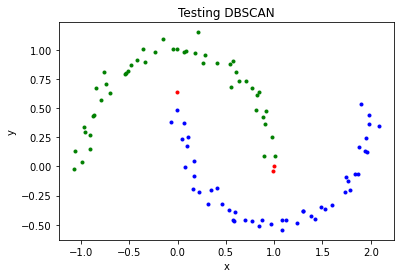

In [20]:
# Plot each cluster
for index, row in df_dbscan.iterrows():
    plt.scatter(row['x'], row['y'], marker = '.', c = symbols[s_cluster_assignment[index]])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing DBSCAN')
plt.show()

## Q2.5 Compare your results to the scikit-learn library

Import DBSCAN from scikit-learn and compare the cluster labels from your implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Add some commentary about how you think the results compare. Use the same data and values for eps and minPts.

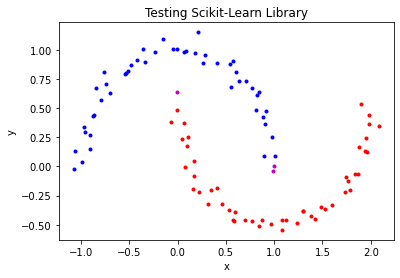

1    100
dtype: int64


In [45]:
# check your implementation vs scikit-learn
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps = 0.23, min_samples = 6).fit(df_dbscan)

for index, row in df_dbscan.iterrows():
    plt.scatter(row['x'], row['y'], marker = '.', c = symbols[clustering.labels_[index]])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Scikit-Learn Library')
plt.show()

diff = pd.Series(s_cluster_assignment) - pd.Series(clustering.labels_)
print(diff.value_counts())

In [46]:
#your obervations about scikit-learn's performance vs your implementation's performance here
print('Our implementation performed identically to the scikit-learn library, with all of the points being classified into the same clusters.')

Our implementation performed identically to the scikit-learn library, with all of the points being classified into the same clusters.
